# **Attrition Risk Modeling**
<br/>by Christian Fernandes

Dataset: https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset?resource=download

In [ ]:
# Use a logistic regression model 

## Reading in the data

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
empattr = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')

In [4]:
empattr.sample(3)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
513,20,Yes,Travel_Rarely,1362,Research & Development,10,1,Medical,1,701,...,4,80,0,1,5,3,1,0,1,1
727,18,No,Non-Travel,287,Research & Development,5,2,Life Sciences,1,1012,...,4,80,0,0,2,3,0,0,0,0
289,28,No,Travel_Rarely,1117,Research & Development,8,2,Life Sciences,1,395,...,4,80,0,5,3,3,5,3,0,2


In [7]:
empattr.dtypes

Age                          int64
Attrition                   object
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EmployeeNumber               int64
EnvironmentSatisfaction      int64
Gender                      object
HourlyRate                   int64
JobInvolvement               int64
JobLevel                     int64
JobRole                     object
JobSatisfaction              int64
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
Over18                      object
OverTime                    object
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StandardHours                int64
StockOptionLevel             int64
TotalWorkingYears   

In [11]:
objcols = [c for c in empattr.columns if empattr[c].dtype == 'O']

In [9]:
catcols = ["Education", "EnvironmentSatisfaction", "JobInvolvement", "JobSatisfaction", "PerformanceRating", "RelationshipSatisfaction", "WorkLifeBalance"]

In [12]:
objcols

['Attrition',
 'BusinessTravel',
 'Department',
 'EducationField',
 'Gender',
 'JobRole',
 'MaritalStatus',
 'Over18',
 'OverTime']

In [16]:
# Check to see if any of the object type columns are in the categorical column list defined in the IBM metadata
# Result is an empty set
set(objcols).intersection(set(catcols))

set()

## EDA

In [93]:
def plot_figure(tibble, colname, plot_title = None, xlab = None, ylab = None, fig_type = None):
    plt.title(plot_title)
    if xlab:
        plt.xlabel(xlab)
    if ylab:
        plt.ylabel(ylab)
    
    if fig_type:
        if fig_type == 'hist':
            tibble[colname].hist(grid = False)
        elif fig_type == 'boxplot':
            tibble[colname].boxplot(grid = False)
        elif fig_type == 'bar':
            tibble[colname].bar(grid = False)
        return True
    return False

In [29]:
# Descriptive statistics for the categorical data

# First ensure all columns are of the 'object' type - similar to R's as.factor() command
empattr_obj = empattr[objcols + catcols].astype(object)

In [27]:
empattr_obj.describe()

,Attrition,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime,Education,EnvironmentSatisfaction,JobInvolvement,JobSatisfaction,PerformanceRating,RelationshipSatisfaction,WorkLifeBalance
count,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470
unique,2,3,3,6,2,9,3,1,2,5,4,4,4,2,4,4
top,No,Travel_Rarely,Research & Development,Life Sciences,Male,Sales Executive,Married,Y,No,3,3,3,4,3,3,3
freq,1233,1043,961,606,882,326,673,1470,1054,572,453,868,459,1244,459,893


Already, we can see for some of the observations that a majority of the employees in this dataset did not quit their jobs (Attrition = No). We can also see that a large proportion of observations are male employees (they make up a majority relative to the other gender 'female').   

In [ ]:
# plot_figure(tibble, colname, plot_title = None, xlab = None, ylab = None, fig_type = None)

True

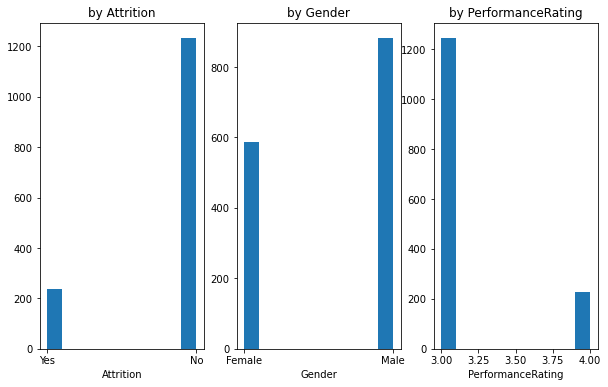

In [96]:
fig, ax = plt.subplots(1,3, figsize = (10, 6))
plt.subplot(1,3,1)
plot_figure(empattr, 'Attrition', 'by Attrition', xlab = 'Attrition', ylab = None, fig_type = 'hist')
plt.subplot(1,3,2)
plot_figure(empattr, 'Gender', 'by Gender', xlab = 'Gender',ylab = None, fig_type = 'hist')
plt.subplot(1,3,3)
plot_figure(empattr, 'PerformanceRating', 'by PerformanceRating',xlab = "PerformanceRating",ylab = None, fig_type = 'hist')


In [40]:
# Descriptive statistics for the numerical data

# Grabbing all of the columns that were not identified as categorical (not in the empattr_obj dataframe)
empattr_numerical_cols = list(set(empattr.columns.tolist()).difference(set(objcols + catcols)))

In [42]:
empattr[empattr_numerical_cols].describe()

,DistanceFromHome,NumCompaniesWorked,HourlyRate,Age,PercentSalaryHike,StandardHours,YearsSinceLastPromotion,MonthlyRate,YearsAtCompany,MonthlyIncome,YearsInCurrentRole,TrainingTimesLastYear,TotalWorkingYears,JobLevel,DailyRate,EmployeeCount,StockOptionLevel,EmployeeNumber,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000
mean,9.192517,2.693197,65.891156,36.923810,15.209524,80.0,2.187755,14313.103401,7.008163,6502.931293,4.229252,2.799320,11.279592,2.063946,802.485714,1.0,0.793878,1024.865306,4.123129
std,8.106864,2.498009,20.329428,9.135373,3.659938,0.0,3.222430,7117.786044,6.126525,4707.956783,3.623137,1.289271,7.780782,1.106940,403.509100,0.0,0.852077,602.024335,3.568136
min,1.000000,0.000000,30.000000,18.000000,11.000000,80.0,0.000000,2094.000000,0.000000,1009.000000,0.000000,0.000000,0.000000,1.000000,102.000000,1.0,0.000000,1.000000,0.000000
25%,2.000000,1.000000,48.000000,30.000000,12.000000,80.0,0.000000,8047.000000,3.000000,2911.000000,2.000000,2.000000,6.000000,1.000000,465.000000,1.0,0.000000,491.250000,2.000000
50%,7.000000,2.000000,66.000000,36.000000,14.000000,80.0,1.000000,14235.500000,5.000000,4919.000000,3.000000,3.000000,10.000000,2.000000,802.000000,1.0,1.000000,1020.500000,3.000000
75%,14.000000,4.000000,83.750000,43.000000,18.000000,80.0,3.000000,20461.500000,9.000000,8379.000000,7.000000,3.000000,15.000000,3.000000,1157.000000,1.0,1.000000,1555.750000,7.000000
max,29.000000,9.000000,100.000000,60.000000,25.000000,80.0,15.000000,26999.000000,40.000000,19999.000000,18.000000,6.000000,40.000000,5.000000,1499.000000,1.0,3.000000,2068.000000,17.000000


True

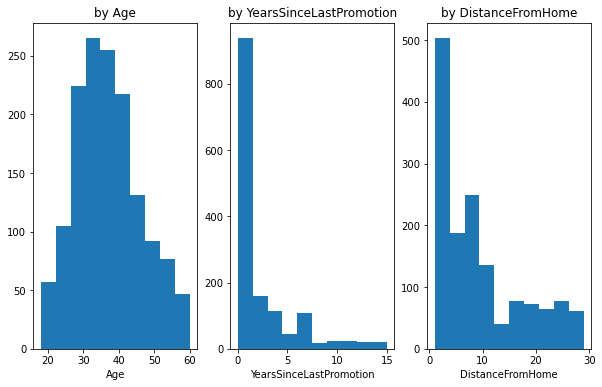

In [91]:
fig, ax = plt.subplots(1,3, figsize = (10, 6))
plt.subplot(1,3,1)
plot_figure(empattr, 'Age', 'by Age', 'Age', None, 'hist')
plt.subplot(1,3,2)
plot_figure(empattr, 'YearsSinceLastPromotion', 'by YearsSinceLastPromotion', 'YearsSinceLastPromotion', None, 'hist')
plt.subplot(1,3,3)
plot_figure(empattr, 'DistanceFromHome', 'by DistanceFromHome', 'DistanceFromHome', None, 'hist')

Let's suppose that the variables age, YearsSinceLastPromotion, and DistanceFromHome would all provide predictive power  for whether or not an employee will leave the company. 

We can run a logistic regression model using these three variables and assess if the model provides accurate predictions. 

Otherwise, if not we can potentially consider a full model with all of the available predicting variables and see if a test for a subset of coefficients would be statistically significant.

If so, then we can proceed with using variable selection techniques to find the best subset of coefficients that yield accurate predictions subject to AIC, BIC, or Mallow's Cp.